<h1>Advanced techniques for NLP, including POST, NER, Word Embeddings and Deep Learning</h1>


# Analysis preparation


## Load packages

In [84]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Data

We load the `20 newsgroup` data from `scikit-learn`. 

In order to make the analysis more difficult, we are removing from the text the headers, footers and quotes. Why? This kind of data contains newsgroup specific wording, email addresses and formats that can be used by the system to learn artificially (this will not be easily found in real world) features of each category.

In [67]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train',  remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',  remove=('headers', 'footers', 'quotes'))

### Shape tha data as DataFrames

In [68]:
train_df = pd.DataFrame(newsgroups_train.data, columns=['Text'])
train_df['Target'] = newsgroups_train.target
test_df = pd.DataFrame(newsgroups_test.data, columns=['Text'])
test_df['Target'] = newsgroups_test.target

### Glimpse the data

In [69]:
train_df.head()

,Text,Target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [70]:
test_df.head()

,Text,Target
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [71]:
train_df.shape, test_df.shape

((11314, 2), (7532, 2))

In [72]:
print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


# Data exploration


Let's explore the data.

In [73]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [74]:
missing_data(train_df)

,Text,Target
Total,0,0
Percent,0,0
Types,object,int32


In [75]:
missing_data(test_df)

,Text,Target
Total,0,0
Percent,0,0
Types,object,int32


In [89]:
stopwords = set(STOPWORDS)
def show_wordcloud(feature,df,title="",size=2):
    data = df.loc[~df[feature].isnull(), feature].values
    count = (~df[feature].isnull()).sum()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(size*4, size*4))
    plt.axis('off')
    fig.suptitle("Prevalent words in {} {} ({} rows)".format(title,feature,count), fontsize=np.sqrt(size)*15)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

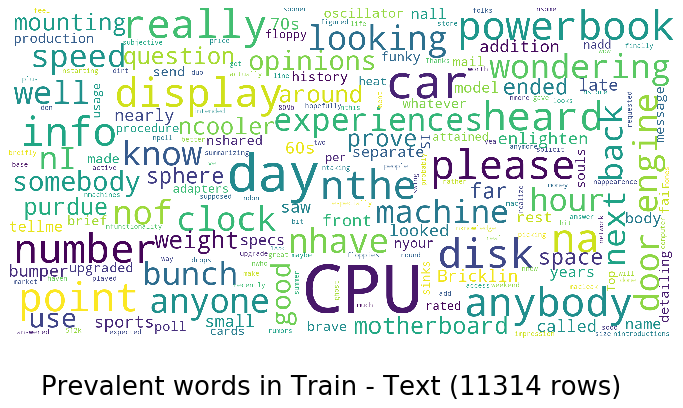

In [103]:
show_wordcloud('Text',train_df, 'Train -',size=3)

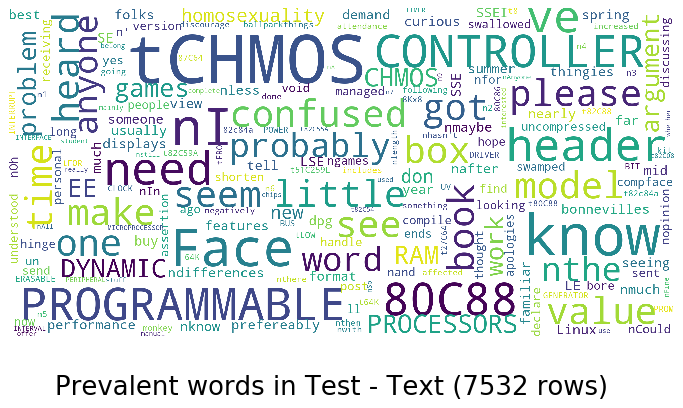

In [104]:
show_wordcloud('Text',test_df, 'Test -',size=3)

Let's look to few specific news channels.

* alt.atheism
* soc.religion.christian
* comp.graphics


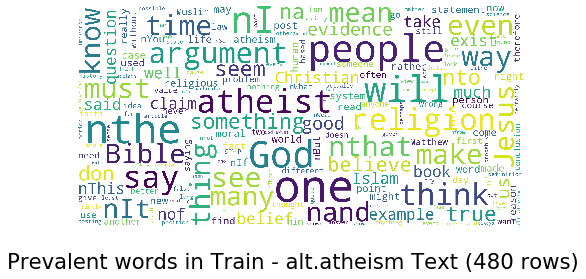

In [92]:
show_wordcloud('Text',train_df.loc[train_df.Target==0], 'Train - alt.atheism')

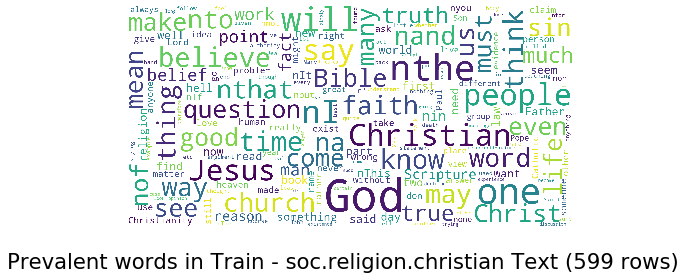

In [93]:
show_wordcloud('Text',train_df.loc[train_df.Target==15], 'Train - soc.religion.christian')

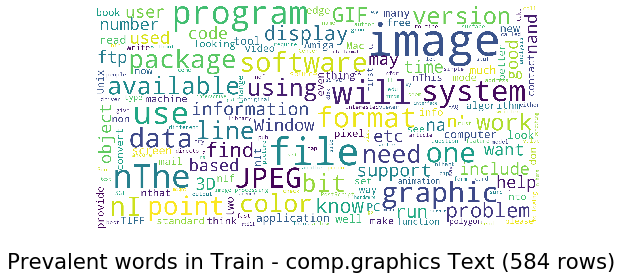

In [94]:
show_wordcloud('Text',train_df.loc[train_df.Target==1], 'Train - comp.graphics') 

Let's look now to the number of words of each doc in train and test.

In [96]:
train_df['Text_Length'] = train_df['Text'].apply(lambda x: len(x.split(" ")))
test_df['Text_Length'] = test_df['Text'].apply(lambda x: len(x.split(" ")))

In [97]:
def plot_features_distribution_categories(feature, feature_sel, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    feature_sel_cat = list(df[feature_sel].unique())
    for feature_cat in feature_sel_cat:
        filter_df = df.loc[df[feature_sel] == feature_cat]
        if(filter_df.shape[0] > 1):            
            if(isLog):
                sns.distplot(np.log1p(filter_df[feature]),kde=True,hist=False, bins=120, label=feature_cat)
            else:
                sns.distplot(filter_df[feature],kde=True,hist=False, bins=120, label=feature_cat)
    plt.xlabel('')
    plt.legend()
    plt.show()

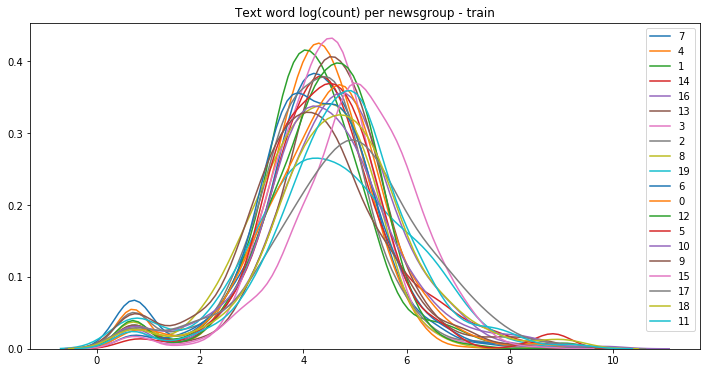

In [101]:
plot_features_distribution_categories('Text_Length', 'Target', 'Text word log(count) per newsgroup - train'A, train_df, isLog=True)

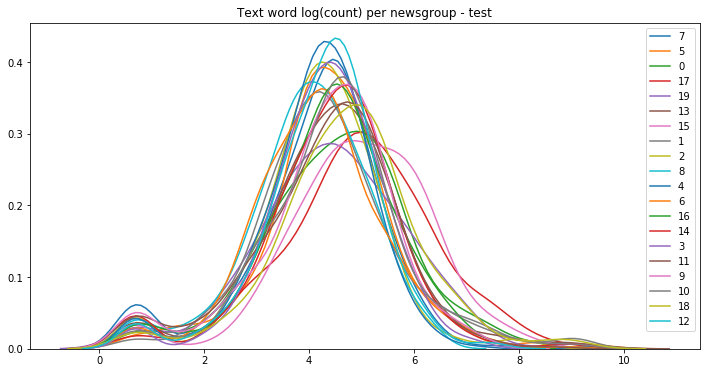

In [102]:
plot_features_distribution_categories('Text_Length', 'Target', 'Text word log(count) per newsgroup - test', test_df, isLog=True)

In [105]:
train_df['Char_Length'] = train_df['Text'].apply(lambda x: len(x))
test_df['Char_Length'] = test_df['Text'].apply(lambda x: len(x))

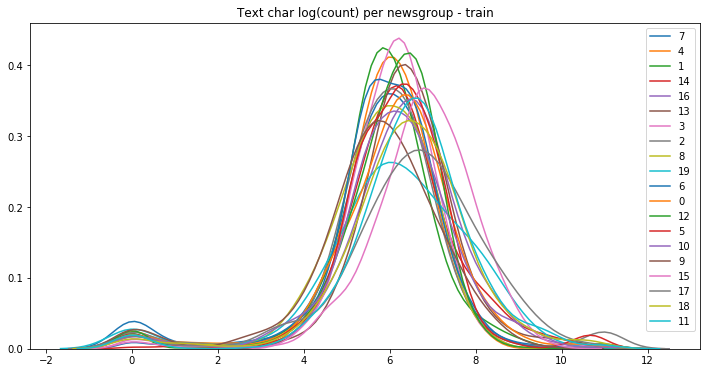

In [107]:
plot_features_distribution_categories('Char_Length', 'Target', 'Text char log(count) per newsgroup - train', train_df, isLog=True)

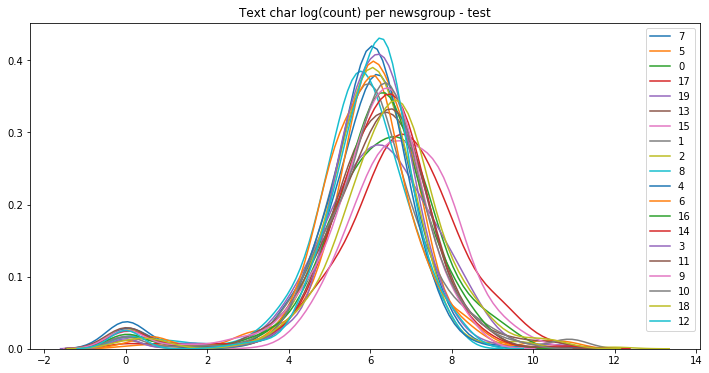

In [108]:
plot_features_distribution_categories('Char_Length', 'Target', 'Text char log(count) per newsgroup - test', test_df, isLog=True)

In [109]:
train_df.head()

,Text,Target,Text_Length,Char_Length
0,I was wondering if anyone out there could enli...,7,86,475
1,A fair number of brave souls who upgraded thei...,4,83,530
2,"well folks, my mac plus finally gave up the gh...",4,295,1659
3,\nDo you have Weitek's address/phone number? ...,1,15,95
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,66,448


# Text Vectorization

We use TF-IDF for text vectorization. We are just using default parameters.

In [110]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_df['Text'])
vectors.shape

(11314, 101631)

# Model using NB

In [111]:
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, train_df['Target'])

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [112]:
vectors_test = vectorizer.transform(test_df['Text'])

pred = clf.predict(vectors_test)
metrics.f1_score(test_df['Target'], pred, average='macro')

0.682861129525057

In [113]:
print(metrics.classification_report(test_df['Target'], pred, target_names=newsgroups_train.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.57      0.44      0.50       319
           comp.graphics       0.65      0.71      0.68       389
 comp.os.ms-windows.misc       0.72      0.52      0.60       394
comp.sys.ibm.pc.hardware       0.59      0.71      0.65       392
   comp.sys.mac.hardware       0.72      0.70      0.71       385
          comp.windows.x       0.81      0.74      0.78       395
            misc.forsale       0.83      0.72      0.77       390
               rec.autos       0.75      0.73      0.74       396
         rec.motorcycles       0.76      0.73      0.75       398
      rec.sport.baseball       0.93      0.81      0.87       397
        rec.sport.hockey       0.60      0.93      0.73       399
               sci.crypt       0.72      0.75      0.74       396
         sci.electronics       0.72      0.58      0.64       393
                 sci.med       0.82      0.78      0.80       396
         

The performance using simple Text vectorization and NB is results in performance of around 0.7 for precision, recall & f1-score (both macro and weighted).

Let's experiment now with more procedures.

# Text preprocessing


We define a class for text normalization. 
Using this class, we can apply the text normalization to the text.

In [158]:
import unicodedata
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords
    
    def lemmatize(self, token):
        return self.lemmatizer.lemmatize(token)
    
    def normalize(self, document):
        return [
            #self.lemmatize(token, tag).lower()
            self.lemmatize(token).lower()
            for paragraph in document
            for sentence in paragraph
            #for (token, tag) in sentence
            for (token) in sentence
            #if not self.is_punct(token) and not self.is_stopword(token)
        ]
    
 #   def lemmatize(self, token, pos_tag):
 #       tag = {
 #           'N': wn.NOUN,
 #           'V': wn.VERB,
 #           'R': wn.ADV,
 #           'J': wn.ADJ
 #       }.get(pos_tag[0], wn.NOUN)

 #       return self.lemmatizer.lemmatize(token, tag)


    
    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document)

In [159]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', TfidfVectorizer()),
    ('bayes', MultinomialNB()),
])

In [160]:
model.fit(train_df['Text'], train_df['Target'])

AttributeError: 'list' object has no attribute 'lower'